In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
0.0      1800
1.0      1296
2.0      1260
3.0      1218
4.0      1026
5.0      1008
6.0       930
7.0       912
8.0       880
9.0       798
10.0      792
11.0      759
12.0      729
13.0      720
14.0      702
15.0      693
16.0      672
17.0      640
18.0      625
19.0      570
20.0      546
21.0      506
22.0      483
23.0      448
24.0      432
25.0      384
26.0      360
27.0      360
28.0      320
29.0      312
         ... 
343.0      12
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      11
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      10
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

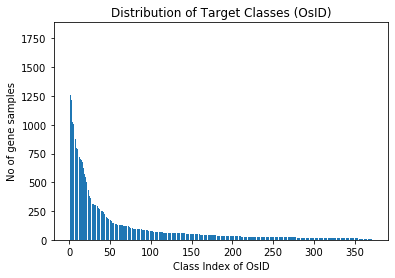

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A colu

Number of input features: 1
Fold: 1
Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 4.4490 - accuracy: 0.1051 - val_loss: 4.0046 - val_accuracy: 0.1443
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6849 - accuracy: 0.1811 - val_loss: 3.6665 - val_accuracy: 0.2218
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3642 - accuracy: 0.2350 - val_loss: 3.4290 - val_accuracy: 0.2559
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1070 - accuracy: 0.2740 - val_loss: 3.2026 - val_accuracy: 0.2519
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.8971 - accuracy: 0.3131 - val_loss: 3.0604 - val_accuracy: 0.2922
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.7306 - accuracy: 0.3478 - val_loss: 2.9659 - val_accuracy: 0.3195
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6058 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.1933 - accuracy: 0.1571 - val_loss: 3.5170 - val_accuracy: 0.1879
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9040 - accuracy: 0.3873 - val_loss: 2.7164 - val_accuracy: 0.4323
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.2098 - accuracy: 0.5189 - val_loss: 2.1500 - val_accuracy: 0.5417
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7082 - accuracy: 0.5921 - val_loss: 1.7517 - val_accuracy: 0.6244
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4174 - accuracy: 0.6408 - val_loss: 1.5763 - val_accuracy: 0.6255
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2450 - accuracy: 0.6763 - val_loss: 1.4300 - val_accuracy: 0.6409
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1298 - accuracy: 0.7021 - val_loss: 1.3198 - val_accuracy: 0.72

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.7268 - accuracy: 0.3034 - val_loss: 2.8224 - val_accuracy: 0.4387
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2117 - accuracy: 0.5559 - val_loss: 2.0228 - val_accuracy: 0.6139
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5647 - accuracy: 0.6521 - val_loss: 1.5924 - val_accuracy: 0.6770
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2149 - accuracy: 0.7086 - val_loss: 1.3486 - val_accuracy: 0.7245
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.0145 - accuracy: 0.7419 - val_loss: 1.2846 - val_accuracy: 0.7065
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8907 - accuracy: 0.7641 - val_loss: 1.0871 - val_accuracy: 0.7683
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8078 - accuracy: 0.7782 - val_loss: 0.9952 - val_accuracy: 0.79

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.8021 - accuracy: 0.2988 - val_loss: 2.8126 - val_accuracy: 0.5569
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0575 - accuracy: 0.6033 - val_loss: 1.8625 - val_accuracy: 0.6290
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3520 - accuracy: 0.7172 - val_loss: 1.3643 - val_accuracy: 0.7461
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.9703 - accuracy: 0.7807 - val_loss: 1.1316 - val_accuracy: 0.7558
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7659 - accuracy: 0.8136 - val_loss: 0.9034 - val_accuracy: 0.8339
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6335 - accuracy: 0.8433 - val_loss: 0.7950 - val_accuracy: 0.8638
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5578 - accuracy: 0.8569 - val_loss: 0.7225 - val_accuracy: 0.86

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5969 - accuracy: 0.3394 - val_loss: 2.4527 - val_accuracy: 0.5655
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7412 - accuracy: 0.6788 - val_loss: 1.5215 - val_accuracy: 0.7228
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.0527 - accuracy: 0.7852 - val_loss: 1.0922 - val_accuracy: 0.8064
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7365 - accuracy: 0.8318 - val_loss: 0.8783 - val_accuracy: 0.8462
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5802 - accuracy: 0.8613 - val_loss: 0.7313 - val_accuracy: 0.8682
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4867 - accuracy: 0.8799 - val_loss: 0.6815 - val_accuracy: 0.8807
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4260 - accuracy: 0.8950 - val_loss: 0.6000 - val_accuracy: 0.88

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5149 - accuracy: 0.3655 - val_loss: 2.3722 - val_accuracy: 0.5813
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5724 - accuracy: 0.7057 - val_loss: 1.3024 - val_accuracy: 0.7624
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8716 - accuracy: 0.8225 - val_loss: 0.8725 - val_accuracy: 0.8482
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5710 - accuracy: 0.8734 - val_loss: 0.7194 - val_accuracy: 0.8834
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4279 - accuracy: 0.8969 - val_loss: 0.5498 - val_accuracy: 0.8955
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3561 - accuracy: 0.9108 - val_loss: 0.5208 - val_accuracy: 0.9124
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3060 - accuracy: 0.9233 - val_loss: 0.5020 - val_accuracy: 0.89

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5557 - accuracy: 0.3529 - val_loss: 2.3181 - val_accuracy: 0.5958
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5728 - accuracy: 0.7187 - val_loss: 1.3343 - val_accuracy: 0.7758
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8930 - accuracy: 0.8219 - val_loss: 0.9283 - val_accuracy: 0.8264
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6092 - accuracy: 0.8670 - val_loss: 0.7172 - val_accuracy: 0.8640
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4642 - accuracy: 0.8902 - val_loss: 0.6092 - val_accuracy: 0.9010
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3877 - accuracy: 0.9039 - val_loss: 0.5550 - val_accuracy: 0.8917
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3337 - accuracy: 0.9191 - val_loss: 0.4999 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4363 - accuracy: 0.3742 - val_loss: 2.2233 - val_accuracy: 0.6194
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4464 - accuracy: 0.7314 - val_loss: 1.2322 - val_accuracy: 0.7771
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8063 - accuracy: 0.8284 - val_loss: 0.8757 - val_accuracy: 0.8392
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5390 - accuracy: 0.8791 - val_loss: 0.6850 - val_accuracy: 0.8818
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4200 - accuracy: 0.9020 - val_loss: 0.5871 - val_accuracy: 0.8981
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3523 - accuracy: 0.9171 - val_loss: 0.5485 - val_accuracy: 0.8922
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3067 - accuracy: 0.9265 - val_loss: 0.4861 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.2149 - accuracy: 0.4191 - val_loss: 1.9518 - val_accuracy: 0.6689
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2482 - accuracy: 0.7672 - val_loss: 1.0602 - val_accuracy: 0.8288
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7121 - accuracy: 0.8476 - val_loss: 0.7821 - val_accuracy: 0.8396
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5098 - accuracy: 0.8820 - val_loss: 0.6540 - val_accuracy: 0.8658
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4013 - accuracy: 0.9016 - val_loss: 0.5997 - val_accuracy: 0.8832
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3395 - accuracy: 0.9139 - val_loss: 0.4752 - val_accuracy: 0.9160
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2943 - accuracy: 0.9263 - val_loss: 0.4594 - val_accuracy: 0.92

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.3866 - accuracy: 0.3877 - val_loss: 2.1284 - val_accuracy: 0.6477
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3662 - accuracy: 0.7379 - val_loss: 1.1754 - val_accuracy: 0.7793
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7527 - accuracy: 0.8346 - val_loss: 0.8328 - val_accuracy: 0.8361
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5256 - accuracy: 0.8736 - val_loss: 0.6488 - val_accuracy: 0.8792
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3993 - accuracy: 0.9031 - val_loss: 0.5659 - val_accuracy: 0.8948
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3364 - accuracy: 0.9169 - val_loss: 0.4996 - val_accuracy: 0.9168
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2971 - accuracy: 0.9238 - val_loss: 0.4615 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4616 - accuracy: 0.3634 - val_loss: 2.2233 - val_accuracy: 0.6066
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4465 - accuracy: 0.7226 - val_loss: 1.2345 - val_accuracy: 0.7804
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7857 - accuracy: 0.8354 - val_loss: 0.8827 - val_accuracy: 0.8460
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5268 - accuracy: 0.8806 - val_loss: 0.7029 - val_accuracy: 0.8785
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4019 - accuracy: 0.9017 - val_loss: 0.5860 - val_accuracy: 0.9023
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3266 - accuracy: 0.9196 - val_loss: 0.5358 - val_accuracy: 0.9045
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2841 - accuracy: 0.9272 - val_loss: 0.5278 - val_accuracy: 0.89

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4816 - accuracy: 0.3673 - val_loss: 2.2317 - val_accuracy: 0.6251
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4030 - accuracy: 0.7275 - val_loss: 1.2223 - val_accuracy: 0.7947
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7597 - accuracy: 0.8465 - val_loss: 0.8309 - val_accuracy: 0.8519
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5085 - accuracy: 0.8906 - val_loss: 0.6433 - val_accuracy: 0.8959
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3880 - accuracy: 0.9095 - val_loss: 0.6141 - val_accuracy: 0.8948
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3165 - accuracy: 0.9259 - val_loss: 0.4885 - val_accuracy: 0.9300
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2719 - accuracy: 0.9370 - val_loss: 0.4689 - val_accuracy: 0.92

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.3266 - accuracy: 0.3836 - val_loss: 1.9971 - val_accuracy: 0.6796
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2536 - accuracy: 0.7674 - val_loss: 1.0518 - val_accuracy: 0.8101
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6533 - accuracy: 0.8607 - val_loss: 0.7243 - val_accuracy: 0.8777
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4355 - accuracy: 0.9011 - val_loss: 0.6018 - val_accuracy: 0.9061
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3387 - accuracy: 0.9216 - val_loss: 0.5213 - val_accuracy: 0.9234
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2906 - accuracy: 0.9294 - val_loss: 0.4734 - val_accuracy: 0.9186
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2523 - accuracy: 0.9388 - val_loss: 0.5240 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4877 - accuracy: 0.3682 - val_loss: 2.2876 - val_accuracy: 0.6334
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4826 - accuracy: 0.7386 - val_loss: 1.2698 - val_accuracy: 0.7868
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8095 - accuracy: 0.8354 - val_loss: 0.8817 - val_accuracy: 0.8323
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5333 - accuracy: 0.8814 - val_loss: 0.6743 - val_accuracy: 0.8807
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3977 - accuracy: 0.9078 - val_loss: 0.5740 - val_accuracy: 0.8933
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3287 - accuracy: 0.9236 - val_loss: 0.4826 - val_accuracy: 0.9153
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2804 - accuracy: 0.9345 - val_loss: 0.4468 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4929 - accuracy: 0.3569 - val_loss: 2.1907 - val_accuracy: 0.6440
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3989 - accuracy: 0.7486 - val_loss: 1.2841 - val_accuracy: 0.8033
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7535 - accuracy: 0.8474 - val_loss: 0.9283 - val_accuracy: 0.8165
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4702 - accuracy: 0.8983 - val_loss: 0.8129 - val_accuracy: 0.8563
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3489 - accuracy: 0.9213 - val_loss: 0.5510 - val_accuracy: 0.9168
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2830 - accuracy: 0.9372 - val_loss: 0.4844 - val_accuracy: 0.9366
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2464 - accuracy: 0.9408 - val_loss: 0.4534 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.1825 - accuracy: 0.4155 - val_loss: 2.0176 - val_accuracy: 0.6466
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3406 - accuracy: 0.7486 - val_loss: 1.1887 - val_accuracy: 0.8048
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7442 - accuracy: 0.8504 - val_loss: 0.8191 - val_accuracy: 0.8717
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4747 - accuracy: 0.9007 - val_loss: 0.6269 - val_accuracy: 0.9017
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3462 - accuracy: 0.9240 - val_loss: 0.5647 - val_accuracy: 0.9182
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2772 - accuracy: 0.9338 - val_loss: 0.5054 - val_accuracy: 0.9155
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2405 - accuracy: 0.9435 - val_loss: 0.4627 - val_accuracy: 0.90

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.0443 - accuracy: 0.4487 - val_loss: 1.7725 - val_accuracy: 0.6895
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.1635 - accuracy: 0.7750 - val_loss: 1.0204 - val_accuracy: 0.8200
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6609 - accuracy: 0.8540 - val_loss: 0.7203 - val_accuracy: 0.8726
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4373 - accuracy: 0.8969 - val_loss: 0.5891 - val_accuracy: 0.8821
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3310 - accuracy: 0.9169 - val_loss: 0.5181 - val_accuracy: 0.9067
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2730 - accuracy: 0.9331 - val_loss: 0.4808 - val_accuracy: 0.9111
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2317 - accuracy: 0.9432 - val_loss: 0.4080 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4822 - accuracy: 0.3226 - val_loss: 2.2213 - val_accuracy: 0.6057
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5118 - accuracy: 0.7128 - val_loss: 1.2701 - val_accuracy: 0.7773
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8542 - accuracy: 0.8350 - val_loss: 0.9456 - val_accuracy: 0.8440
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5718 - accuracy: 0.8812 - val_loss: 0.7167 - val_accuracy: 0.8801
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4229 - accuracy: 0.9066 - val_loss: 0.6384 - val_accuracy: 0.8979
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3272 - accuracy: 0.9278 - val_loss: 0.5523 - val_accuracy: 0.9144
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2863 - accuracy: 0.9314 - val_loss: 0.4812 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4181 - accuracy: 0.3424 - val_loss: 2.1896 - val_accuracy: 0.5883
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4412 - accuracy: 0.7340 - val_loss: 1.2416 - val_accuracy: 0.8009
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7979 - accuracy: 0.8440 - val_loss: 0.9382 - val_accuracy: 0.8310
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5082 - accuracy: 0.8958 - val_loss: 0.6767 - val_accuracy: 0.9061
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3525 - accuracy: 0.9246 - val_loss: 0.6130 - val_accuracy: 0.9118
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2894 - accuracy: 0.9351 - val_loss: 0.5197 - val_accuracy: 0.9276
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2414 - accuracy: 0.9454 - val_loss: 0.5060 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.2440 - accuracy: 0.3989 - val_loss: 2.0113 - val_accuracy: 0.6546
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2861 - accuracy: 0.7547 - val_loss: 1.1211 - val_accuracy: 0.8009
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7070 - accuracy: 0.8499 - val_loss: 0.7670 - val_accuracy: 0.8548
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4580 - accuracy: 0.8928 - val_loss: 0.5849 - val_accuracy: 0.9025
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3426 - accuracy: 0.9169 - val_loss: 0.5022 - val_accuracy: 0.9030
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2870 - accuracy: 0.9249 - val_loss: 0.4562 - val_accuracy: 0.9199
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2458 - accuracy: 0.9370 - val_loss: 0.3705 - val_accuracy: 0.94

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

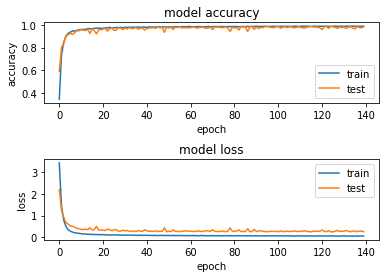

Final Test Accuracy: 0.9899756908416748


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.99      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         334              334        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True


In [14]:
print(models_df)

    No of input features  Model accuracy
0                      1           0.524
1                      2           0.884
2                      3           0.937
3                      4           0.970
4                      5           0.976
5                      6           0.979
6                      7           0.979
7                      8           0.989
8                      9           0.986
9                     10           0.987
10                    11           0.985
11                    12           0.987
12                    13           0.981
13                    14           0.982
14                    15           0.982
15                    16           0.989
16                    17           0.987
17                    18           0.985
18                    19           0.990
19                    20           0.987
